# ITT-MCT Schematic Model: LAOS (Large Amplitude Oscillatory Shear)

## Learning Objectives

1. Fit the **ITT-MCT Schematic (F₁₂)** model to LAOS data
2. Extract **Fourier harmonics** using `get_laos_harmonics()`
3. Analyze nonlinear viscoelastic response beyond linear G', G''
4. Understand strain-induced yielding and cage breaking in oscillatory flow
5. Compare first and third harmonic contributions

## Prerequisites

- Basic RheoJAX usage
- NB05: Schematic SAOS (recommended for linear response context)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTSchematic

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from itt_mct_tutorial_utils import (
    load_carbopol_laos,
    save_itt_mct_results,
    print_convergence_summary,
    print_parameter_comparison,
    print_glass_state_summary,
    compute_fit_quality,
    get_schematic_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: LAOS and Fourier Rheology

### Linear vs Nonlinear Response

**SAOS (Small Amplitude)**: γ(t) = γ₀sin(ωt) with γ₀ << γc
- Linear response: σ(t) = γ₀[G'sin(ωt) + G''cos(ωt)]
- Only first harmonic present

**LAOS (Large Amplitude)**: γ(t) = γ₀sin(ωt) with γ₀ ~ γc or larger
- Nonlinear response: σ(t) contains odd harmonics
- σ(t) = Σₙ [σ'ₙsin(nωt) + σ''ₙcos(nωt)] for n = 1, 3, 5, ...

### Fourier Decomposition

The stress response is decomposed as:
$$
\sigma(t) = \sum_{n=1,3,5,...} \left[ \sigma'_n \sin(n\omega t) + \sigma''_n \cos(n\omega t) \right]
$$

**Physical meaning**:
- σ'₁, σ''₁: First harmonic (elastic/viscous storage/loss)
- σ'₃, σ''₃: Third harmonic (nonlinearity indicator)
- |σ₃/σ₁|: Measures deviation from linearity

### MCT Picture of LAOS

In Mode-Coupling Theory:
- At small γ₀: Correlator Φ oscillates but stays near equilibrium
- At large γ₀: Periodic cage breaking and reformation
- Decorrelation h(γ(t)) introduces nonlinearity

### Lissajous-Bowditch Curves

Plotting σ vs γ (or σ vs γ̇) reveals:
- **Ellipse**: Linear viscoelastic (SAOS)
- **Distorted shapes**: Nonlinear (LAOS)
- **Area**: Energy dissipation per cycle

## 3. Load Data

We use LAOS data from the PNAS dataset at ω = 1 rad/s with moderate strain amplitude.

In [3]:
# Load LAOS data
OMEGA = 1.0  # rad/s
AMPLITUDE_INDEX = 5  # Moderate amplitude

time_data, strain_data, stress_data = load_carbopol_laos(
    omega=OMEGA, 
    strain_amplitude_index=AMPLITUDE_INDEX
)

# Estimate strain amplitude from data
gamma_0 = np.max(np.abs(strain_data))

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Strain amplitude: γ₀ ≈ {gamma_0:.4f}")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")
print(f"Angular frequency: ω = {OMEGA} rad/s")

Data points: 1000
Time range: [0.0053, 66.00] s
Strain amplitude: γ₀ ≈ 0.5120
Stress range: [-17.36, 25.30] Pa
Angular frequency: ω = 1.0 rad/s


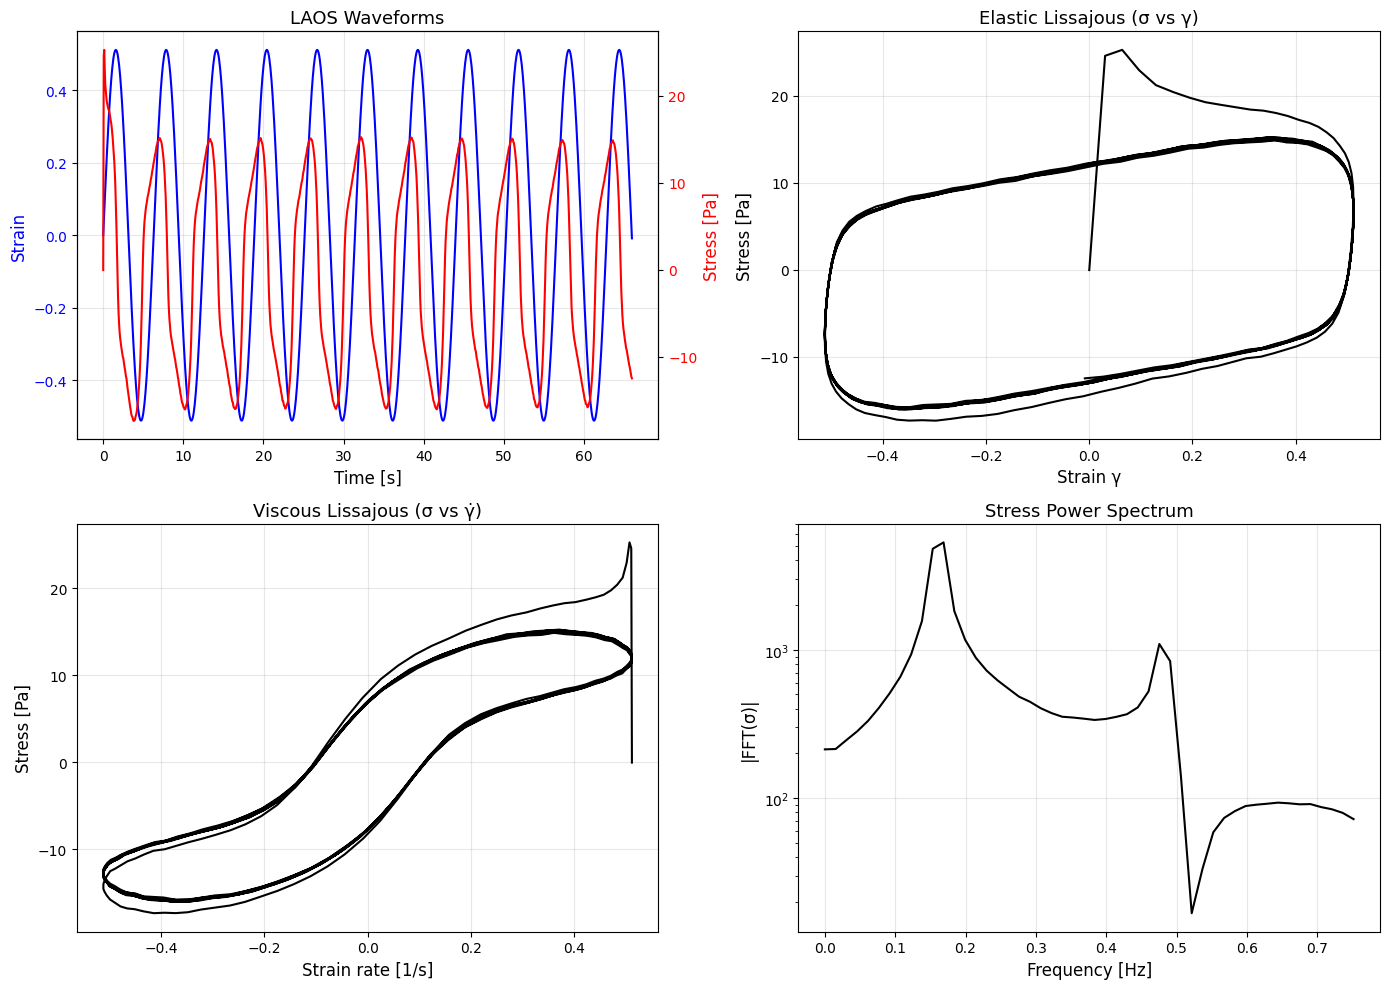

In [4]:
# Plot raw LAOS data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Stress and strain vs time
ax1 = axes[0, 0]
ax1.plot(time_data, strain_data, 'b-', lw=1.5, label='Strain γ(t)')
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('Strain', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1b = ax1.twinx()
ax1b.plot(time_data, stress_data, 'r-', lw=1.5, label='Stress σ(t)')
ax1b.set_ylabel('Stress [Pa]', fontsize=12, color='red')
ax1b.tick_params(axis='y', labelcolor='red')
ax1.set_title('LAOS Waveforms', fontsize=13)
ax1.grid(True, alpha=0.3)

# Top right: Elastic Lissajous (σ vs γ)
ax2 = axes[0, 1]
ax2.plot(strain_data, stress_data, 'k-', lw=1.5)
ax2.set_xlabel('Strain γ', fontsize=12)
ax2.set_ylabel('Stress [Pa]', fontsize=12)
ax2.set_title('Elastic Lissajous (σ vs γ)', fontsize=13)
ax2.grid(True, alpha=0.3)

# Bottom left: Viscous Lissajous (σ vs γ̇)
ax3 = axes[1, 0]
gamma_dot_data = gamma_0 * OMEGA * np.cos(OMEGA * time_data)  # Approximate
ax3.plot(gamma_dot_data, stress_data, 'k-', lw=1.5)
ax3.set_xlabel('Strain rate [1/s]', fontsize=12)
ax3.set_ylabel('Stress [Pa]', fontsize=12)
ax3.set_title('Viscous Lissajous (σ vs γ̇)', fontsize=13)
ax3.grid(True, alpha=0.3)

# Bottom right: Power spectrum
ax4 = axes[1, 1]
# Simple FFT for visualization
n = len(stress_data)
fft_stress = np.abs(np.fft.rfft(stress_data))
freqs = np.fft.rfftfreq(n, d=(time_data[1] - time_data[0]))
ax4.semilogy(freqs[:50], fft_stress[:50], 'k-', lw=1.5)
ax4.set_xlabel('Frequency [Hz]', fontsize=12)
ax4.set_ylabel('|FFT(σ)|', fontsize=12)
ax4.set_title('Stress Power Spectrum', fontsize=13)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create model
model = ITTMCTSchematic(epsilon=0.05)

print("Initial model state:")
print(model)
print()
print_glass_state_summary(model)

Initial model state:
ITTMCTSchematic(ε=0.050 [glass], v₂=4.20, h(γ)=gaussian, m=simplified, σ=schematic, G_inf=1.00e+06 Pa)


Glass Transition State
State: GLASS
Separation parameter: epsilon = 0.0500
Non-ergodicity parameter: f = 0.2381
  -> Correlator plateaus at f > 0 (arrested dynamics)
  -> Material shows yield stress


In [6]:
# Fit to LAOS data
param_names = ["v2", "Gamma", "gamma_c", "G_inf"]

t0 = time.time()
model.fit(time_data, stress_data, test_mode="laos", gamma_0=gamma_0, omega=OMEGA, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 107.24 s

Fitted parameters:
  v2         = 4.199
  Gamma      = 52.27
  gamma_c    = 0.09432
  G_inf      = 9.999e+05


In [7]:
# Compute fit quality
stress_pred = model.predict(time_data, test_mode="laos", gamma_0=gamma_0, omega=OMEGA)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R²:   {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R²:   -44282909.034939
  RMSE: 7.719e+04 Pa
  NRMSE: 180931.8298%


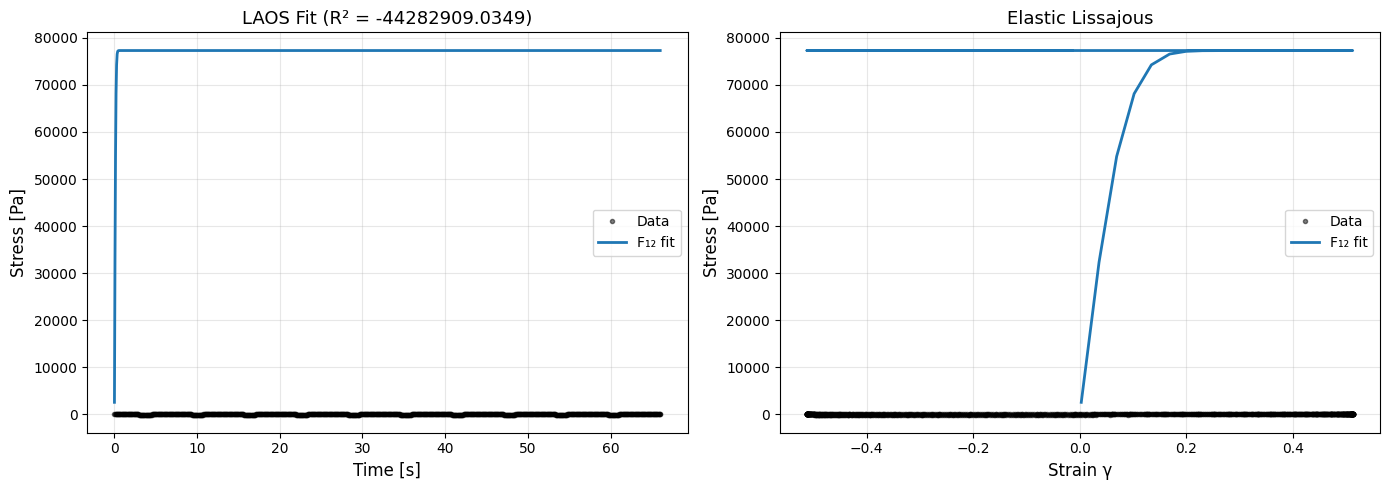

In [8]:
# Plot fit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Time series
ax1 = axes[0]
ax1.plot(time_data, stress_data, 'ko', markersize=3, alpha=0.5, label='Data')
ax1.plot(time_data, stress_pred, '-', lw=2, color='C0', label='F₁₂ fit')
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('Stress [Pa]', fontsize=12)
ax1.set_title(f'LAOS Fit (R² = {metrics["R2"]:.4f})', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Lissajous comparison
ax2 = axes[1]
ax2.plot(strain_data, stress_data, 'ko', markersize=3, alpha=0.5, label='Data')
strain_pred = gamma_0 * np.sin(OMEGA * time_data)
ax2.plot(strain_pred, stress_pred, '-', lw=2, color='C0', label='F₁₂ fit')
ax2.set_xlabel('Strain γ', fontsize=12)
ax2.set_ylabel('Stress [Pa]', fontsize=12)
ax2.set_title('Elastic Lissajous', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Fourier Harmonic Analysis

In [9]:
# Extract Fourier harmonics using model method
time_fine = np.linspace(0, 4 * np.pi / OMEGA, 500)  # 2 full periods

sigma_prime, sigma_double_prime = model.get_laos_harmonics(
    time_fine, 
    gamma_0=gamma_0, 
    omega=OMEGA,
    n_harmonics=5
)

print("LAOS Fourier Harmonics")
print("=" * 50)
print(f"{'Harmonic':>10s}  {'σ\' (in-phase)':>15s}  {'σ\"(out-phase)':>15s}  {'Ratio to 1st':>12s}")
print("-" * 50)

for i, n in enumerate([1, 3, 5, 7, 9]):
    if i < len(sigma_prime):
        sp = sigma_prime[i]
        spp = sigma_double_prime[i]
        ratio = np.sqrt(sp**2 + spp**2) / np.sqrt(sigma_prime[0]**2 + sigma_double_prime[0]**2)
        print(f"{n:>10d}  {sp:>15.4g}  {spp:>15.4g}  {ratio:>12.4f}")

LAOS Fourier Harmonics
  Harmonic    σ' (in-phase)    σ"(out-phase)  Ratio to 1st
--------------------------------------------------
         1           -201.3            -2513        1.0000
         3           -583.8            -2405        0.9816
         5           -910.9            -2205        0.9463
         7            -1158            -1943        0.8971
         9            -1317            -1651        0.8379


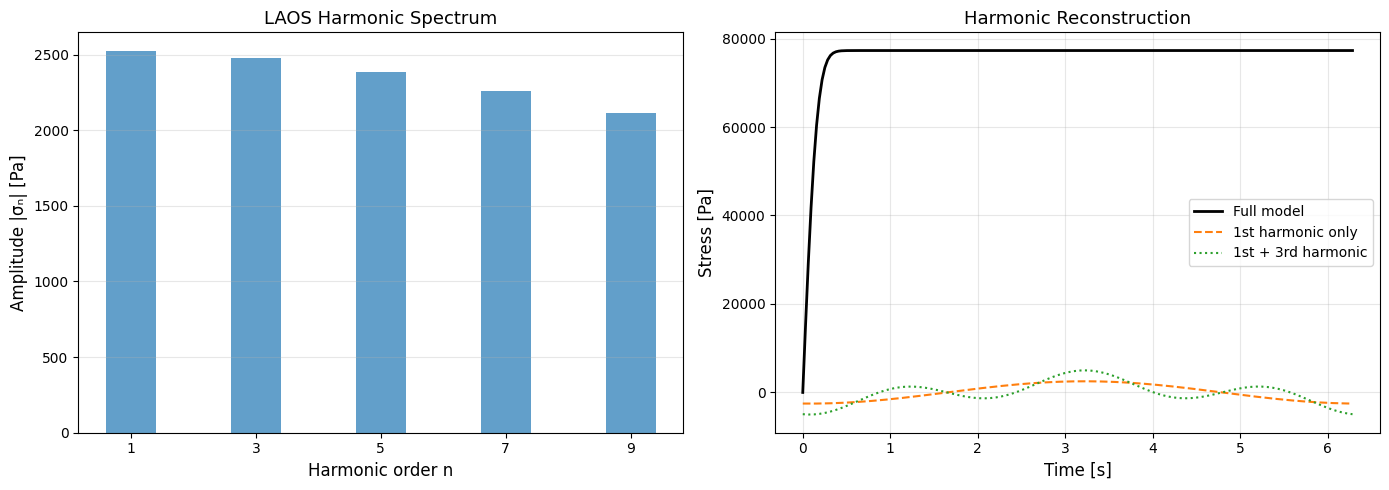

In [10]:
# Visualize harmonics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Harmonic amplitudes
ax1 = axes[0]
harmonics = [1, 3, 5, 7, 9][:len(sigma_prime)]
amplitudes = np.sqrt(np.array(sigma_prime)**2 + np.array(sigma_double_prime)**2)
ax1.bar(harmonics, amplitudes, color='C0', alpha=0.7)
ax1.set_xlabel('Harmonic order n', fontsize=12)
ax1.set_ylabel('Amplitude |σₙ| [Pa]', fontsize=12)
ax1.set_title('LAOS Harmonic Spectrum', fontsize=13)
ax1.set_xticks(harmonics)
ax1.grid(True, alpha=0.3, axis='y')

# Right: Reconstruct stress from harmonics
ax2 = axes[1]
t_recon = np.linspace(0, 2*np.pi/OMEGA, 200)

# First harmonic only (linear)
sigma_1 = sigma_prime[0] * np.sin(OMEGA * t_recon) + sigma_double_prime[0] * np.cos(OMEGA * t_recon)

# First + third harmonic
sigma_13 = sigma_1.copy()
if len(sigma_prime) > 1:
    sigma_13 += sigma_prime[1] * np.sin(3*OMEGA * t_recon) + sigma_double_prime[1] * np.cos(3*OMEGA * t_recon)

# Full prediction
sigma_full = model.predict(t_recon, test_mode="laos", gamma_0=gamma_0, omega=OMEGA)

ax2.plot(t_recon, sigma_full, 'k-', lw=2, label='Full model')
ax2.plot(t_recon, sigma_1, '--', lw=1.5, color='C1', label='1st harmonic only')
ax2.plot(t_recon, sigma_13, ':', lw=1.5, color='C2', label='1st + 3rd harmonic')
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('Stress [Pa]', fontsize=12)
ax2.set_title('Harmonic Reconstruction', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

In [11]:
# Nonlinearity analysis
print("\nNonlinearity Analysis")
print("=" * 50)

# Third harmonic ratio (common measure of nonlinearity)
if len(sigma_prime) > 1:
    I3_I1 = np.sqrt(sigma_prime[1]**2 + sigma_double_prime[1]**2) / \
            np.sqrt(sigma_prime[0]**2 + sigma_double_prime[0]**2)
    print(f"Third harmonic ratio: I₃/I₁ = {I3_I1:.4f}")
    print(f"  I₃/I₁ << 0.01: Linear regime")
    print(f"  I₃/I₁ ~ 0.01-0.1: Weakly nonlinear")
    print(f"  I₃/I₁ > 0.1: Strongly nonlinear")

# Compare to critical strain
gamma_c = model.parameters.get_value("gamma_c")
print(f"\nStrain amplitude γ₀ = {gamma_0:.4f}")
print(f"Critical strain γc = {gamma_c:.4f}")
print(f"Ratio γ₀/γc = {gamma_0/gamma_c:.2f}")
if gamma_0 < gamma_c:
    print("  → Linear/weakly nonlinear regime expected")
else:
    print("  → Nonlinear regime expected")


Nonlinearity Analysis
Third harmonic ratio: I₃/I₁ = 0.9816
  I₃/I₁ << 0.01: Linear regime
  I₃/I₁ ~ 0.01-0.1: Weakly nonlinear
  I₃/I₁ > 0.1: Strongly nonlinear

Strain amplitude γ₀ = 0.5120
Critical strain γc = 0.0943
Ratio γ₀/γc = 5.43
  → Nonlinear regime expected


## 6. Bayesian Inference

In [12]:
try:
    # Prepare warm-start
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    print("Warm-start values:")
    for name, val in initial_values.items():
        print(f"  {name:10s} = {val:.4g}")
    
    # Fast demo config
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    
    print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        time_data,
        stress_data,
        test_mode="laos",
        gamma_0=gamma_0,
        omega=OMEGA,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:NUTS sampling failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 648, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 643, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_stat

ERROR:rheojax.core.bayesian:bayesian_inference failed: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 648, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 643, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_state(
  

Warm-start values:
  v2         = 4.199
  Gamma      = 52.27
  gamma_c    = 0.09432
  G_inf      = 9.999e+05

Running NUTS: 200 warmup + 500 samples x 1 chain(s)
Note: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.
NLSQ results are reported above.


In [13]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [14]:
if result is not None:
    # Trace plots
    idata = result.to_inference_data()
    axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
    fig = axes.ravel()[0].figure
    fig.suptitle("Trace Plots (LAOS)", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [15]:
if result is not None:
    # Parameter comparison
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 7. Physical Interpretation

### LAOS Response Regimes

1. **Linear regime (γ₀ << γc)**:
   - Only first harmonic significant
   - Lissajous curves are ellipses
   - G', G'' from SAOS apply

2. **Nonlinear regime (γ₀ ~ γc)**:
   - Third and higher harmonics emerge
   - Lissajous curves distort
   - Strain stiffening/softening visible

3. **Strongly nonlinear (γ₀ >> γc)**:
   - Cage breaking dominates
   - Plastic flow during part of cycle
   - Pronounced higher harmonics

In [16]:
# Summary
print("LAOS Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nLAOS Parameters:")
print(f"  Strain amplitude: γ₀ = {gamma_0:.4f}")
print(f"  Angular frequency: ω = {OMEGA} rad/s")
print(f"  Critical strain: γc = {model.parameters.get_value('gamma_c'):.4f}")
if len(sigma_prime) > 1:
    print(f"  Third harmonic ratio: I₃/I₁ = {I3_I1:.4f}")

LAOS Summary

Glass Transition State
State: GLASS
Separation parameter: epsilon = 0.0499
Non-ergodicity parameter: f = 0.2381
  -> Correlator plateaus at f > 0 (arrested dynamics)
  -> Material shows yield stress

LAOS Parameters:
  Strain amplitude: γ₀ = 0.5120
  Angular frequency: ω = 1.0 rad/s
  Critical strain: γc = 0.0943
  Third harmonic ratio: I₃/I₁ = 0.9816


## 8. Save Results

In [17]:
# Save results
save_itt_mct_results(model, result, "schematic", "laos", param_names)
print("\nLAOS results saved.")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/itt_mct/../utils/../outputs/itt_mct/schematic/laos/
  nlsq_params_laos.json: 4 parameters

LAOS results saved.


## Key Takeaways

1. **LAOS** probes nonlinear viscoelastic response through Fourier harmonics

2. **Third harmonic ratio** I₃/I₁ quantifies nonlinearity

3. **Critical strain γc** determines onset of nonlinear response

4. **Lissajous curves** reveal strain stiffening/softening and yielding

5. **MCT** captures LAOS through strain-dependent decorrelation h(γ(t))

6. **`get_laos_harmonics()`** extracts in-phase (σ') and out-of-phase (σ'') coefficients

### References

- Ewoldt, Hosoi & McKinley (2008) J. Rheol. - LAOS framework
- Brader et al. (2008) J. Phys.: Condens. Matter - MCT under LAOS